value means srcID, dstID

In [1]:
import dgl
import torch as th
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz as pgv
import torch
import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


#### Build the graph

In [2]:
f1 = h5py.File('./mesh_path.h5','r')
f2 = h5py.File('./path_reac.h5','r')
f3 = h5py.File('./reac_reac.h5','r')

In [3]:
src1 = f1['src']
src2 = f2['src']
src3 = f3['src']
dis1 = f1['dis']
dis2 = f2['dis']
dis3 = f3['dis']

In [5]:
graph_data = {
    ('meshDescriptor', 'conclude', 'pathway'): (th.tensor(src1), th.tensor(dis1)),
    ('pathway', 'hasEvent', 'reaction'): (th.tensor(src2), th.tensor(dis2)),
    ('reaction', 'precedingEvent', 'reaction'): (th.tensor(src3), th.tensor(dis3)),
    ('pathway', 'belong', 'meshDescriptor'): (th.tensor(dis1), th.tensor(src1)),
    ('reaction', 'eventOf', 'pathway'): (th.tensor(dis2), th.tensor(src2)),
    ('reaction', 'laterEvent', 'reaction'): (th.tensor(dis3), th.tensor(src3))
}
G = dgl.heterograph(graph_data)
G

Graph(num_nodes={'meshDescriptor': 121, 'pathway': 209, 'reaction': 1277},
      num_edges={('meshDescriptor', 'conclude', 'pathway'): 345, ('pathway', 'hasEvent', 'reaction'): 1289, ('reaction', 'precedingEvent', 'reaction'): 955, ('pathway', 'belong', 'meshDescriptor'): 345, ('reaction', 'eventOf', 'pathway'): 1289, ('reaction', 'laterEvent', 'reaction'): 955},
      metagraph=[('meshDescriptor', 'pathway'), ('pathway', 'reaction'), ('pathway', 'meshDescriptor'), ('reaction', 'reaction'), ('reaction', 'reaction'), ('reaction', 'pathway')])

In [6]:
#G.nodes('pathway')

In [7]:
print('Node types:', G.ntypes)
print('Edge types:', G.etypes)
print('Canonical edge types:', G.canonical_etypes)

Node types: ['meshDescriptor', 'pathway', 'reaction']
Edge types: ['conclude', 'hasEvent', 'precedingEvent', 'belong', 'eventOf', 'laterEvent']
Canonical edge types: [('meshDescriptor', 'conclude', 'pathway'), ('pathway', 'hasEvent', 'reaction'), ('reaction', 'precedingEvent', 'reaction'), ('pathway', 'belong', 'meshDescriptor'), ('reaction', 'eventOf', 'pathway'), ('reaction', 'laterEvent', 'reaction')]


In [8]:
f4 = h5py.File('./label_path.h5','r')
label_pathway = f4['label_pathway']
label_pathway

<HDF5 dataset "label_pathway": shape (209,), type "<i8">

In [9]:
label_pathway = torch.tensor(label_pathway).long()
len(label_pathway)
labels = label_pathway
labels

tensor([  0,   0, 117,   0, 117,  58,   0, 102,  14, 117, 117,   1,   2,  10,
          2,  39,  40,  14,  74, 110,  26, 107,  14,  75,  11,  19,  73,  59,
          8,  11,  62,   9,  62,  97,   9,   9,   9,   9,  12,  11,  28,  45,
         11,  26,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  45,  26,
         11,  11,  24,  11,  11,  45,  75,  11,  26,  86,  73,  11,  75,  11,
         86,  14, 109,  14,  39, 100,  14,  58,  14,  14, 104,  19,  19,  31,
        119,  21,  25,  25,  26,  26,  26,  26,  45,  28,  40,  28,  29,  33,
         33,  33,  33,  75,  38,  39,  40, 102,  40,  40,  40,  63,  95,  41,
         41,  43,  93,  97,  97,  49,  67,  53,  54,  89,  89,  57, 120,  58,
         67,  58,  58, 103,  58,  58, 102,  69,  58,  60,  60,  62,  62,  62,
         63,  65,  65,  65,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,
         67,  67,  67,  67,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
         75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  

In [10]:
pid = list(range(209))
shuffle = np.random.permutation(pid)
train_idx = torch.tensor(shuffle[0:180]).long()
val_idx = torch.tensor(shuffle[160:200]).long()
test_idx = torch.tensor(shuffle[200:]).long()

In [11]:
import dgl.function as fn
class HeteroRGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer, self).__init__()
        # W_r for each relation
        self.weight = nn.ModuleDict({
                name : nn.Linear(in_size, out_size) for name in etypes
            })
    def forward(self, G, feat_dict):
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            Wh = self.weight[etype](feat_dict[srctype])
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        G.multi_update_all(funcs, 'sum')
        return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}

In [12]:
class HeteroRGCN(nn.Module):
    def __init__(self, G, in_size, hidden_size, out_size):
        super(HeteroRGCN, self).__init__()
        # embedding layer for each nodes
        embed_dict = {ntype : nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
                      for ntype in G.ntypes}
        for key, embed in embed_dict.items():
            nn.init.xavier_uniform_(embed)
        self.embed = nn.ParameterDict(embed_dict)
        self.layer1 = HeteroRGCNLayer(in_size, hidden_size, G.etypes)
        self.layer2 = HeteroRGCNLayer(hidden_size, out_size, G.etypes)
    def forward(self, G):
        h_dict = self.layer1(G, self.embed)
        h_dict = {k : F.leaky_relu(h) for k, h in h_dict.items()}
        h_dict = self.layer2(G, h_dict)
        return h_dict['pathway']

In [17]:
model = HeteroRGCN(G, 1024, 1024, 208)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
best_val_acc = 0
best_test_acc = 0
lossFig = []
TraAcc = []
ValAcc = []
ValAcc = []
TesAcc = []
time = list(range(100))

for epoch in range(100):
    logits = model(G)
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])
    pred = logits.argmax(1) 
    train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
    val_acc = (pred[val_idx] == labels[val_idx]).float().mean()
    test_acc = (pred[test_idx] == labels[test_idx]).float().mean()
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print('Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
            loss.item(),
            train_acc.item(),
            val_acc.item(),
            #best_val_acc.item(),
            best_val_acc,
            test_acc.item(),
            #best_test_acc.item(),
            best_test_acc
        ))
    
    lossFig.append(loss.item())
    TraAcc.append(train_acc.item())
    ValAcc.append(val_acc.item())
    TesAcc.append(test_acc.item())

Loss 5.3429, Train Acc 0.0056, Val Acc 0.0000 (Best 0.0000), Test Acc 0.0000 (Best 0.0000)
Loss 0.2627, Train Acc 0.9278, Val Acc 0.8250 (Best 0.8250), Test Acc 0.5556 (Best 0.5556)
Loss 0.0504, Train Acc 0.9833, Val Acc 0.8000 (Best 0.8500), Test Acc 0.6667 (Best 0.6667)
Loss 0.0300, Train Acc 0.9889, Val Acc 0.7500 (Best 0.8500), Test Acc 0.6667 (Best 0.6667)
Loss 0.0542, Train Acc 0.9944, Val Acc 0.7750 (Best 0.8500), Test Acc 0.7778 (Best 0.6667)
Loss 0.0657, Train Acc 0.9944, Val Acc 0.8250 (Best 0.8500), Test Acc 0.7778 (Best 0.6667)
Loss 0.0263, Train Acc 0.9944, Val Acc 0.8250 (Best 0.8500), Test Acc 0.6667 (Best 0.6667)
Loss 0.0330, Train Acc 1.0000, Val Acc 0.8250 (Best 0.8500), Test Acc 0.7778 (Best 0.6667)
Loss 0.0341, Train Acc 1.0000, Val Acc 0.8500 (Best 0.8500), Test Acc 0.7778 (Best 0.6667)
Loss 0.0260, Train Acc 1.0000, Val Acc 0.8500 (Best 0.8500), Test Acc 0.7778 (Best 0.6667)
Loss 0.0326, Train Acc 1.0000, Val Acc 0.8750 (Best 0.8750), Test Acc 0.7778 (Best 0.7778)

#### Save the model

In [22]:
torch.save(model.state_dict(),"./PathwayPredict.pth")

#### Visualize the result

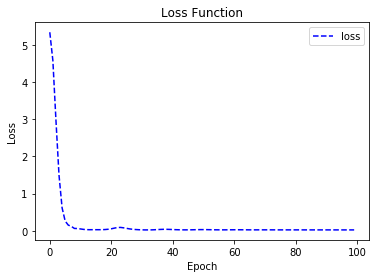

In [18]:
l = plt.plot(time, lossFig, 'b--', label = 'loss')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

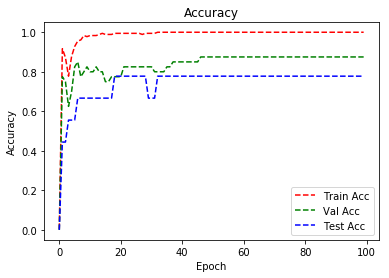

In [19]:
l1 = plt.plot(time, TraAcc, 'r--', label = 'Train Acc')
l2 = plt.plot(time, ValAcc, 'g--', label = 'Val Acc')
l3 = plt.plot(time, TesAcc, 'b--', label = 'Test Acc')
#plt.plot(time, TraAcc,'ro-', time, ValAcc, 'g+-', time, TesAcc, 'b^-')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Draw the meta graph

In [6]:
# 使用 graphviz创建元图.
def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')
plot_graph(G.metagraph)